In [1]:
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation

In [2]:
## Load pre-trained image processing model (glpn-nyu)
feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

In [3]:
## Load and resize image
image = Image.open("data3.jpg").convert("RGB")
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height%32)
new_width = int(new_height * image.width / image.height)
diff = new_width%32

new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)

In [4]:
## Process image into PyTorch tensors
inputs = feature_extractor(images=image, return_tensors="pt")

In [5]:
## Pass inputs through depth estimation model, predicting depth map of image
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

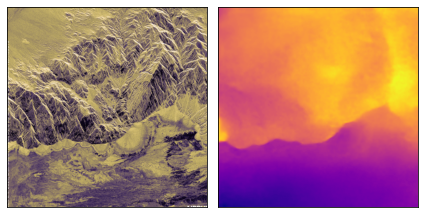

In [6]:
## original image vs. depth map

pad = 16
output = predicted_depth.squeeze().cpu().numpy()*1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))

fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap="plasma")
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)

In [7]:
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
## Open3D Image Object
width, height = image.size
depth_image = (output*255 / np.max(output)).astype('uint8')
image = np.array(image)

depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

In [9]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)

In [10]:
## 3D Point Cloud imagery
pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,camera_intrinsic)
o3d.visualization.draw_geometries([pcd_raw])

In [11]:
## Remove outliers and estimate surface normals
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=6.0)
pcd = pcd_raw.select_by_index(ind)

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

In [12]:
o3d.visualization.draw_geometries([pcd])

In [13]:
## Smooth Mesh imaging
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]
rotation = mesh.get_rotation_matrix_from_xyz((np.pi,0,0))
mesh.rotate(rotation, center=(0,0,0))

TriangleMesh with 452817 points and 904672 triangles.

In [14]:
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [16]:
## 3D Mesh export (Polygon format)

o3d.io.write_triangle_mesh('3dmodel.ply',mesh)

True